<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Generalised_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install firebase-admin
import os 
import math
import cv2
import numpy as np 
import csv
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

In [0]:
#Get Images from Firebase Storage
import datetime
import firebase_admin
from firebase_admin import credentials
from firebase_admin import storage

# Fetch the service account key JSON file contents
cred = credentials.Certificate("credentials.json")

# Initialize the app with a service account, granting admin privileges
app = firebase_admin.initialize_app(cred, {
    'storageBucket': 'fir-4ca2c.appspot.com',
}, name='storage')

In [0]:
def transmission(img, lt = 230, retMean = False):
  ker = np.ones((3, 3))/9.0
  imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  b, g, r = cv2.split(img)
  hsv = cv2.cvtColor(imgrgb, cv2.COLOR_RGB2HSV)
  _, _, v = cv2.split(hsv)
  v_blur = cv2.filter2D(v, -1, ker)
  _,building_mask = cv2.threshold(v_blur, lt, 255, cv2.THRESH_BINARY)
  sky = cv2.bitwise_and(imgrgb, imgrgb, mask = building_mask)
  sky_mask = cv2.bitwise_not(building_mask, building_mask.copy())
  building = cv2.bitwise_and(imgrgb, imgrgb, mask = sky_mask)
 
  al = max(v_blur.flatten())
  #Airlight Found. Now calculate Transmission Map
  img_norm = img/float(al)
  b, g, r = cv2.split(img_norm)
  kernel = np.ones((3,3),np.uint8)
  im_new = np.zeros((img.shape[0], img.shape[1]))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      im_new[i][j] = min(b[i][j], g[i][j], r[i][j])
  dcp = cv2.erode(im_new, kernel, iterations = 1)
  #ax[3].imshow(im_new, cmap = 'gray')
  #ax[4].imshow(dcp, cmap = 'gray')
  tr = np.ones((dcp.shape[0], dcp.shape[1]))
  for i in range(dcp.shape[0]):
    for j in range(dcp.shape[1]):
      tr[i][j] = 1 - dcp[i][j]
  #ax[1].imshow(tr, cmap = 'gray')
  if retMean == False:
    return tr
  elif retMean == True:
    return np.mean(tr)

In [0]:
def entropy(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  hist = cv2.calcHist( [image.astype('float32')],
              [0], 
              None,
               [256], 
              [0,256] )
  h_norm = 0
  h_norm = cv2.normalize(hist, h_norm)
  ent = 0
  for p in h_norm:
    try:
      ent += p*math.log(p, 2)
    except:
      pass
    
  return (-1 * ent[0])

In [0]:
def contrast(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  s = 0
  ss = 0
  mean = np.mean(image)
  x = (-1 * mean * (np.ones(image.shape)))
  ss = np.square(np.add(image, x))
  cont = np.sqrt(np.sum(ss)/float(image.size))
  return cont

In [8]:
#Loading E1 - Lenovo data : 504 -- sscb labels 

data = []
reading = []
t = 0
bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imglenovo = [] #has all the lenovo images by their name 

mits = set()
for blob in blobs:
  if blob.name[7:16]=="lenovoinS" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
      blob.download_to_filename('/content/' + "lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')
      imglenovo.append("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg') 
      print("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')



lenovo2019-06-27 17:01:04.jpeg
lenovo2019-06-27 17:05:48.jpeg
lenovo2019-06-27 17:10:27.jpeg
lenovo2019-06-27 17:15:58.jpeg
lenovo2019-06-27 18:04:29.jpeg
lenovo2019-06-27 18:08:53.jpeg
lenovo2019-06-27 18:17:05.jpeg
lenovo2019-06-27 18:19:07.jpeg
lenovo2019-06-27 18:26:07.jpeg
lenovo2019-06-27 18:28:53.jpeg
lenovo2019-06-27 18:35:27.jpeg
lenovo2019-06-27 18:39:31.jpeg
lenovo2019-06-27 18:47:06.jpeg
lenovo2019-06-27 18:49:07.jpeg
lenovo2019-06-27 18:56:06.jpeg
lenovo2019-06-28 06:00:07.jpeg
lenovo2019-06-28 06:04:07.jpeg
lenovo2019-06-28 06:09:28.jpeg
lenovo2019-06-28 06:14:37.jpeg
lenovo2019-06-28 06:18:53.jpeg
lenovo2019-06-28 06:25:28.jpeg
lenovo2019-06-28 06:29:29.jpeg
lenovo2019-06-28 06:35:27.jpeg
lenovo2019-06-28 06:38:53.jpeg
lenovo2019-06-28 06:44:28.jpeg
lenovo2019-06-28 06:49:29.jpeg
lenovo2019-06-28 06:56:37.jpeg
lenovo2019-06-28 07:00:28.jpeg
lenovo2019-06-28 07:04:07.jpeg
lenovo2019-06-28 07:09:28.jpeg
lenovo2019-06-28 07:13:53.jpeg
lenovo2019-06-28 07:18:53.jpeg
lenovo20

In [0]:
##Loading E2 - Mi data : 760 -- sscb labels 


bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imgminote = [] #has all the minote pictures by their name 

mits = set()
for blob in blobs:
  if blob.name[7:16]=="minoteSSC" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
        print(blob.name)

        blob.download_to_filename('/content/' + "minote" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgminote.append("minote" + str(blob.name.split('/')[-1])+ '.jpeg') 
        print("minote" + str(blob.name.split('/')[-1])+ '.jpeg')


In [9]:
print(len(imgminote))   ##ends on 3rd july only sscb data 
print(len(imglenovo))   ##ends on 4th july 10:30 - sscb + half a day at DTU 

826
603


In [0]:
k=0
im_trans=[]
im_ent=[]
im_cont=[]

for img in imgminote:
  im = cv2.imread(img)
  im = cv2.resize(im, (32,32))
  im_trans.append(transmission(im, retMean = True))
  im_ent.append(entropy(im))
  im_cont.append(contrast(im))
  k+=1
  print(k)
  
print('MINOTES PICTURES OVER')  
print(len(im_trans))


for img in imglenovo:
  im = cv2.imread(img)
  im = cv2.resize(im, (32,32))
  im_trans.append(transmission(im, retMean = True))
  im_ent.append(entropy(im))
  im_cont.append(contrast(im))
  k+=1
  print(k)


  
print('IMGLENOVOS PICTURES OVER')  
print(len(im_trans))



In [12]:
print(len(imglenovo))
print(len(imgminote))

603
826


In [20]:
dict={}
num = len(imglenovo)
print(num)
for i in range(0,num):
  l=[]
  l.append(im_trans[i])
  l.append(im_ent[i])
  l.append(im_cont[i])
  dict[(imglenovo[i])]=l
  
  ##because the next values will be put in the same dict after this ending index 

603


In [14]:
print(dict)

{'lenovo2019-06-27 17:01:04.jpeg': [0.8213759600105932, 42.08242416381836, 56.565832682688196], 'lenovo2019-06-27 17:05:48.jpeg': [0.8054319646860987, 41.52888107299805, 51.499371830340586], 'lenovo2019-06-27 17:10:27.jpeg': [0.906191697761194, 23.427310943603516, 22.633249960040253], 'lenovo2019-06-27 17:15:58.jpeg': [0.7759951636904763, 5.428897857666016, 2.7180139707272217], 'lenovo2019-06-27 18:04:29.jpeg': [0.759033203125, 5.230010032653809, 2.6006590961475515], 'lenovo2019-06-27 18:08:53.jpeg': [0.7889368840767637, 29.528430938720703, 38.687402136560266], 'lenovo2019-06-27 18:17:05.jpeg': [0.771240234375, 5.240905284881592, 2.5989893196006864], 'lenovo2019-06-27 18:19:07.jpeg': [0.6446902252906976, 39.1527214050293, 60.97394543150685], 'lenovo2019-06-27 18:26:07.jpeg': [0.7489304315476191, 5.268103122711182, 2.5575765436824045], 'lenovo2019-06-27 18:28:53.jpeg': [0.73984375, 5.268465042114258, 2.5652071911152925], 'lenovo2019-06-27 18:35:27.jpeg': [0.6258055515552995, 39.82032394

In [0]:
ctr=0
for i in range(num,k):
  l=[]
  l.append(im_trans[i])
  l.append(im_ent[i])
  l.append(im_cont[i])
  dict[(imgminote[ctr])]=l
  ctr+=1
  print(ctr)
  

In [23]:
print(len(dict))

1429


In [0]:
# With flattened transmission
# for img in imgminote:
#   im = cv2.imread(img)
#   im = cv2.resize(im, (32,32))
#   im_trans.append(np.ndarray.flatten(transmission(im, retMean = False)))
#   im_ent.append(entropy(im))
#   im_cont.append(contrast(im))
#   k+=1

# With transmission mean 


In [32]:
#Checking for outliers
ctr=0

#in entropy list 
for im in im_ent:
  if(im<20):
    print(im)
    ctr+=1
    
print(ctr)

#in contrast list 
ctr=0
for im in im_cont:
  if(im<20):
    print(im)
    ctr+=1
    
print(ctr)


5.428897857666016
5.230010032653809
5.240905284881592
5.268103122711182
5.268465042114258
5.130550861358643
15.443744659423828
7
2.7180139707272217
2.6006590961475515
2.5989893196006864
2.5575765436824045
2.5652071911152925
2.5652904668757026
6


In [27]:
k=0
#just checking if all values have been appended properly 
for key in dict:
  k+=1
  if(k==603):
    print(key[:-5])
    print(dict[key])
  if(k==604):
    print(key[:-5])
    print(dict[key])
  if(k==1429):
    print(key)
    print(dict[key])
 

lenovo2019-07-04 10:30:07
[0.6519649110991379, 34.36293029785156, 52.92715655705112]
minote2019-06-27 15:14:35
[0.6542801099785407, 32.90918731689453, 52.685475872794484]
minote2019-07-03 06:29:17.jpeg
[0.8057253370098041, 41.891178131103516, 67.28242413691835]


In [33]:
#converting all image timestamps into cpcb compatible timestamp 
tmp=[]
for key in dict:
  temp=key[-24:-5]
  temp=temp.split('-')
  
  newtemp=temp[2].split(' ')
  
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  tmp.append(final)
  
  
print(tmp)

['27-06-2019 17:00', '27-06-2019 17:00', '27-06-2019 17:15', '27-06-2019 17:15', '27-06-2019 18:00', '27-06-2019 18:15', '27-06-2019 18:15', '27-06-2019 18:15', '27-06-2019 18:30', '27-06-2019 18:30', '27-06-2019 18:30', '27-06-2019 18:45', '27-06-2019 18:45', '27-06-2019 18:45', '27-06-2019 18:00', '28-06-2019 06:00', '28-06-2019 06:00', '28-06-2019 06:15', '28-06-2019 06:15', '28-06-2019 06:15', '28-06-2019 06:30', '28-06-2019 06:30', '28-06-2019 06:30', '28-06-2019 06:45', '28-06-2019 06:45', '28-06-2019 06:45', '28-06-2019 06:00', '28-06-2019 07:00', '28-06-2019 07:00', '28-06-2019 07:15', '28-06-2019 07:15', '28-06-2019 07:15', '28-06-2019 07:30', '28-06-2019 07:30', '28-06-2019 07:30', '28-06-2019 07:45', '28-06-2019 07:45', '28-06-2019 07:45', '28-06-2019 07:00', '28-06-2019 08:00', '28-06-2019 08:00', '28-06-2019 08:15', '28-06-2019 08:15', '28-06-2019 08:15', '28-06-2019 08:30', '28-06-2019 08:30', '28-06-2019 08:30', '28-06-2019 08:45', '28-06-2019 08:45', '28-06-2019 08:45',

In [0]:
i=0
#checking correlation between actual and generated timestamps 
for key in dict:
  print(key)
  print('          ' + tmp[i])
  i+=1

In [0]:
i=0
ecttime=[]
for key in dict:
  l=[]
  l.append(tmp[i])
  l.append(dict[key])
  ecttime.append(l)
  i+=1

##ecttime is the list with modified timestamp matched with e,c,t

In [39]:
print(len(ecttime))

1429


In [113]:
#TEMPORARY FIX - REPLACED ALL NONE BY 0.0 - 153 Reading 
k=0
cpcb=[]
with open('/content/sscb_labels.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>=18):
      l=[]
      l.append(row[0])
      l.append(row[2])
      cpcb.append(l)      
   


  
print(cpcb)


[['27-06-2019 00:00', '61'], ['27-06-2019 00:15', '61'], ['27-06-2019 00:30', '61'], ['27-06-2019 00:45', '61'], ['27-06-2019 01:00', '53'], ['27-06-2019 01:15', '53'], ['27-06-2019 01:30', '53'], ['27-06-2019 01:45', '53'], ['27-06-2019 02:00', '68'], ['27-06-2019 02:15', '68'], ['27-06-2019 02:30', '68'], ['27-06-2019 02:45', '68'], ['27-06-2019 03:00', '72'], ['27-06-2019 03:15', '72'], ['27-06-2019 03:30', '72'], ['27-06-2019 03:45', '72'], ['27-06-2019 04:00', '69'], ['27-06-2019 04:15', '69'], ['27-06-2019 04:30', '69'], ['27-06-2019 04:45', '69'], ['27-06-2019 05:00', '73'], ['27-06-2019 05:15', '73'], ['27-06-2019 05:30', '73'], ['27-06-2019 05:45', '73'], ['27-06-2019 06:00', '161'], ['27-06-2019 06:15', '161'], ['27-06-2019 06:30', '161'], ['27-06-2019 06:45', '161'], ['27-06-2019 07:00', '103'], ['27-06-2019 07:15', '103'], ['27-06-2019 07:30', '103'], ['27-06-2019 07:45', '103'], ['27-06-2019 08:00', '97'], ['27-06-2019 08:15', '97'], ['27-06-2019 08:30', '97'], ['27-06-201

In [114]:
#Checking for missing values and removing those values 

ctr=0
for i in range(0,len(cpcb)-1):
  if(cpcb[i][1]=='NAN'):
    ctr+=1
    pre = float(cpcb[i-1][1])
    post = float(cpcb[i+1][1])
    if(pre ==np.nan):
      print(cpcb[i])
      pre == '0.0'
    if(post==np.nan):
      print(cpcb[i])
      post == '0.0'
    cpcb[i][1]=str((pre +post)/2)
    
    
    
print(ctr)

##checking the last element
if(cpcb[len(cpcb)-1][1]=='NAN'):
  cpcb[len(cpcb)-1][1]=='0.0'

for i in range(0,len(cpcb)):
  if(cpcb[i][1]=='nan'):
    print(cpcb[i])
    cpcb[i][1]='0.0'
  if(cpcb[i][1]=='NaN'):
    print(cpcb[i])
    cpcb[i][1]='0.0'
  


105
['04-07-2019 10:30', 'nan']
['04-07-2019 10:45', 'nan']


In [0]:
final=[]
for e in ecttime:
  for tmp in cpcb:
    if(tmp[0] == e[0]):
      l=[]
      l.append(tmp[0])
      l.append(tmp[1])
      l.append(e[1])
      final.append(l)


In [117]:
print(len(final))

1429


In [118]:
print(final)

[['27-06-2019 17:00', '45', [0.8213759600105932, 42.08242416381836, 56.565832682688196]], ['27-06-2019 17:00', '45', [0.8054319646860987, 41.52888107299805, 51.499371830340586]], ['27-06-2019 17:15', '45', [0.906191697761194, 23.427310943603516, 22.633249960040253]], ['27-06-2019 17:15', '45', [0.7759951636904763, 5.428897857666016, 2.7180139707272217]], ['27-06-2019 18:00', '36', [0.759033203125, 5.230010032653809, 2.6006590961475515]], ['27-06-2019 18:15', '36', [0.7889368840767637, 29.528430938720703, 38.687402136560266]], ['27-06-2019 18:15', '36', [0.771240234375, 5.240905284881592, 2.5989893196006864]], ['27-06-2019 18:15', '36', [0.6446902252906976, 39.1527214050293, 60.97394543150685]], ['27-06-2019 18:30', '36', [0.7489304315476191, 5.268103122711182, 2.5575765436824045]], ['27-06-2019 18:30', '36', [0.73984375, 5.268465042114258, 2.5652071911152925]], ['27-06-2019 18:30', '36', [0.6258055515552995, 39.8203239440918, 62.1486148201111]], ['27-06-2019 18:45', '36', [0.7317693929

In [119]:
#the entropy and contrast are drastically different - 6 pm 
print(final[0])
print(im_ent[0])

print(min(im_ent))
print(min(im_cont))
print(max(im_ent))
print(max(im_cont))

['27-06-2019 17:00', '45', [0.8213759600105932, 42.08242416381836, 56.565832682688196]]
42.08242416381836
5.130550861358643
2.5575765436824045
50.83211135864258
86.38470004830313


In [0]:
#Feature engineering
hours=[]
trans=[]
cont=[]
ent=[]
pm=[]

for e in final:
  #print(e[0][-5:-3])
  hours.append(int(e[0][-5:-3]))
  #print(e[1])
  pm.append(float(e[1]))
  #print(e[2][0])
  trans.append(float(e[2][0]))
  ent.append(float(e[2][1]))
  cont.append(float(e[2][2]))


In [121]:
print(len(hours))
print(hours)
print(len(trans))
print(trans)
print(len(cont))
print(cont)
print(len(ent))
print(ent)
print(len(pm))
print(pm)

1429
[17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 

In [123]:
# k=0
# for i in range(0,1239):
#   if(np.isnan([p])==True):
#     pm[i]=0.0
final_shape=len(hours)
hours = np.reshape(hours,(final_shape,1))
trans = np.reshape(trans,(final_shape,1))
cont = np.reshape(cont,(final_shape,1))
ent = np.reshape(ent,(final_shape,1))
pm = np.reshape(pm,(final_shape,1))


scaler = StandardScaler()

hours = scaler.fit_transform(hours)
trans = scaler.fit_transform(trans)
cont = scaler.fit_transform(cont)
ent = scaler.fit_transform(ent)


features = np.hstack((hours, cont, ent, trans))
print(features)


[[ 1.25398274 -0.84622591  0.49501299  1.53353485]
 [ 1.25398274 -1.44768923  0.3868596   1.2866169 ]
 [ 1.25398274 -4.8745219  -3.14989535  2.84704051]
 ...
 [-1.54911093 -0.31496173  1.21973644  0.70848809]
 [-1.54911093 -0.19605052  0.91587271  0.88893145]
 [-1.54911093  0.4259909   0.4576466   1.29116024]]


In [0]:
def learning_curve(model, X, y):
  x_train, x_test, y_train , y_test = train_test_split(features, pm, test_size = 0.3, random_state = 42 )
  val_error=[]
  train_error=[]
  for m in range(1, len(x_train)):
    reg.fit(x_train[:m], y_train[:m])
    test_pred = reg.predict(x_test)
    train_pred = reg.predict(x_train[:m])
    val_error.append(np.sqrt(mean_squared_error(test_pred, y_test)))
    train_error.append(np.sqrt(mean_squared_error(train_pred , y_train[:m])))
    

  plt.plot(val_error,"r-" ,label = 'Validation error')
  plt.plot(train_error,"b-" ,label = 'train error ')

28.482354269836076
19.690037352940394


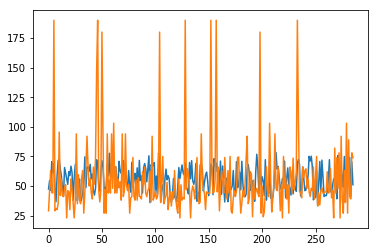

In [142]:
#Linear REGRESSOR 
reg = LinearRegression(normalize =True)

x_train, x_test, y_train, y_test = train_test_split(features, pm, test_size =0.2, random_state =42)

reg.fit(x_train, y_train)

pred = reg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)
print(mean_absolute_error(pred, y_test))




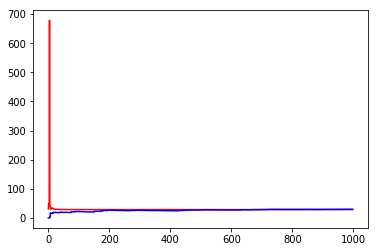

In [143]:
learning_curve(reg, features, pm)

In [130]:
shape = np.shape(pred)

pred = np.reshape(pred, shape)
y_test = np.reshape(y_test, shape)
result = np.hstack((pred, y_test))
print(result)


[[ 47.39004449  29.        ]
 [ 54.49779301  47.        ]
 [ 46.32805034  63.        ]
 [ 70.50236495  44.5       ]
 [ 60.93064448  44.        ]
 [ 68.95704923 190.        ]
 [ 48.05485424  29.        ]
 [ 36.70020212  31.        ]
 [ 58.60666144  30.        ]
 [ 71.53764805  35.        ]
 [ 72.67473962  95.5       ]
 [ 64.20757923  42.        ]
 [ 58.52289695  56.        ]
 [ 49.18921128  41.5       ]
 [ 41.48613926  41.        ]
 [ 65.58595906  48.        ]
 [ 60.9883631   51.        ]
 [ 56.01832317  23.        ]
 [ 51.38084253  46.        ]
 [ 62.05504976  45.        ]
 [ 58.71949988  30.        ]
 [ 66.69755178  56.        ]
 [ 61.30818853  47.        ]
 [ 37.90769638  36.        ]
 [ 55.86548468  23.        ]
 [ 67.78606801  38.        ]
 [ 69.36178434  94.        ]
 [ 37.45595874  35.        ]
 [ 48.65461273  59.5       ]
 [ 55.85629363  39.        ]
 [ 36.90951134  35.        ]
 [ 39.41763772  57.        ]
 [ 44.34468973  63.        ]
 [ 52.12247733  27.        ]
 [ 74.58718913

In [131]:
print(max(np.diff(result)))
print(min(np.diff(result)))

[121.43687012]
[-36.6924876]


In [158]:
print(np.shape(features))
print(np.shape(pm))

print(type(hours))
print(type(cont))
print(type(ent))
print(type(trans))
print(type(pm))

(1429, 4)
(1429, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


(1429, 4)
(1429, 1)
28.46449074297445
19.575803154602617


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


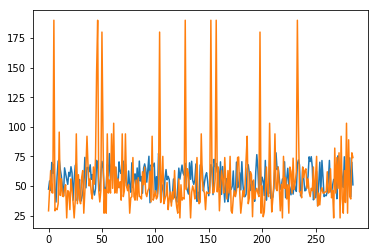

In [156]:
reg = SGDRegressor(penalty = 'elasticnet')

features = np.hstack((hours, cont, ent, trans))
x_train, x_test, y_train, y_test = train_test_split(features, pm, test_size =0.2, random_state =42)
reg.fit(x_train,y_train)

pred = reg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)
print(mean_absolute_error(pred, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_o

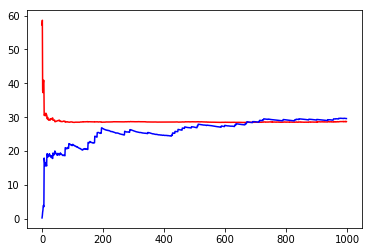

In [145]:
learning_curve(reg, features, pm)

In [153]:
shape = np.shape(pred)
print(shape)
pred = np.reshape(pred,shape)
print(np.shape(pred))
y_test = np.reshape(y_test, shape)
print(np.shape(y_test))
result = np.hstack((pred, y_test))

print(result)

(286,)
(286,)
(286,)
[ 47.0274222   54.66693826  45.9655438   69.62076701  61.19467416
  68.42620529  47.72430945  36.21281573  57.89607064  70.88540325
  72.23718562  64.1661666   58.78571767  49.206907    41.24547785
  65.48381319  60.33174373  55.44785562  51.24308777  61.44658452
  58.11533067  66.13376696  61.62639785  37.64251045  55.2769632
  67.03404317  68.99363526  37.0966788   48.48999441  55.61268129
  36.62677653  39.24660905  44.40280845  51.66586181  74.25911251
  48.482155    65.76002928  65.6869396   62.21801749  68.18021879
  56.03349322  60.03035417  46.21775414  42.12508409  47.96561131
  71.63681846  68.75735514  48.04240474  45.66914781  60.79377309
  70.80077571  65.29605059  49.16239133  45.77433194  49.61885139
  67.92178946  58.35000119  77.37373698  55.02804438  68.09245237
  73.1401609   71.81739175  50.37680891  65.76047575  53.54189074
  48.75895388  70.55189278  62.58337885  60.97156608  67.94745089
  71.20442636  52.49493088  68.32305354  50.42364268  48

21.72211195341901
13.584144967269161


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


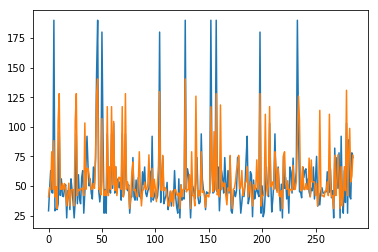

In [154]:
reg = RandomForestRegressor(max_depth=4)
reg.fit(x_train, y_train)
pred = reg.predict(x_test)


plt.plot(y_test)
plt.plot(pred)
print(mean_squared_error(pred, y_test)**0.5)
print(mean_absolute_error(pred, y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was pas

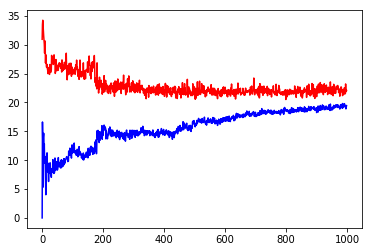

In [155]:
learning_curve(reg, features, pm)

In [0]:
#adding weather features to the data
import json 

with open('/content/weather_data.json') as file:
  data = json.loads(file) #loading data for processing 
  print(json.dumps(file, indent = 4 ))
  